In [1]:
# 库文件
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from skopt import gp_minimize
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import train_test_split

import numpy as np
from scipy.optimize import minimize
from sklearn.metrics.pairwise import rbf_kernel


In [2]:
#差分方程  # 生成数据
def nonlinear_system(y1_k, y2_k, u1_k, u2_k, u1_k_1, u2_k_1):
    # 生成噪声
    noise_level = 0.01
    noise1 = np.random.normal(loc=0, scale=np.sqrt(noise_level))
    noise2 = np.random.normal(loc=0, scale=np.sqrt(noise_level))
    # 计算输出
    output1 = y1_k / (1 + y2_k**2) + u1_k + 0.2 * u2_k + 0.4 * u1_k_1 + 0.1 * u2_k_1 + noise1
    output2 = y1_k * y2_k / (1 + y2_k**2) + 0.3 * u1_k + u2_k + 0.1 * u1_k_1 + 0.5 * u2_k_1 + noise2
    return output1, output2


# 参数设置
num_samples = 301
y1_data, y2_data = np.zeros(num_samples), np.zeros(num_samples)

# 初始化初始条件
y1_data[0], y2_data[0] = 1.0, 0.5

# 生成输入数据在[-1, 1]之间
u1_data = np.random.uniform(-1, 1, num_samples)
u2_data = np.random.uniform(-1, 1, num_samples)
u1_data_1 = np.roll(u1_data, 1)
u2_data_1 = np.roll(u2_data, 1)
u1_data_1[0], u2_data_1[0] = 0, 0  # 设置第一个时刻的上一个时刻输入为0



# 生成数据
for k in range(0, num_samples-1):
    print(k)
    y1_data[k+1], y2_data[k+1] = nonlinear_system(y1_data[k], y2_data[k], u1_data[k], u2_data[k], u1_data_1[k], u2_data_1[k])



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [3]:
#组合训练数据  多输入单输出
# 假设有训练数据 u1_data, u2_data, y1_data 和 y1_data+1
# 将它们组合成输入特征矩阵 X 和输出标签向量 y
u1_data = u1_data
u2_data = u2_data
u1_data_1 = np.roll(u1_data, 1)
u2_data_1 = np.roll(u2_data, 1)
u1_data_1[0], u2_data_1[0] = 0, 0

y1_data = y1_data

X = np.column_stack((u1_data[:-1], u2_data[:-1], u1_data_1[:-1], u2_data_1[:-1], y1_data[:-1]))
y = y1_data[1:]
print(X.shape,y.shape)
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3333, random_state=42)




(300, 5) (300,)


In [4]:
# 定义My_LS_SVRModel

class My_LS_SVRModel:
    def __init__(self, params):
        self.C = params[0]
        self.gamma = params[1]
        self.W_b = None
        self.X_train = None

    def model_train(self, X_train, y_train, K_train):
        def objective(W_b, X, y, C):
            y_pred = np.dot(K_train, W_b[:-1]) + W_b[-1]
            errors = y - y_pred
            loss = 0.5 * np.dot(W_b[:-1], W_b[:-1]) + C * np.sum(errors**2)
            return loss

        initial_W_b = np.zeros(X_train.shape[0] + 1)
        result = minimize(objective, initial_W_b, args=(X_train, y_train, self.C), method='L-BFGS-B')
        best_W_b = result.x
        return best_W_b

    def fit(self, X_train, y_train):
        self.X_train = X_train
        K_train = rbf_kernel(X_train, X_train, gamma=self.gamma)
        self.W_b = self.model_train(X_train, y_train, K_train)

    def predict(self, X_test):
        K_test = rbf_kernel(X_test, self.X_train, gamma=self.gamma)
        y_pred = np.dot(K_test, self.W_b[:-1]) + self.W_b[-1]
        return y_pred
    

# # 示例用法
# params = [8.78525340e+01, 2.01347249e-03]
# # 创建模型
# my_svr_model = My_LS_SVRModel(params=params)
# # 训练模型
# my_svr_model.fit(X_train, y_train)
# # 模型预测
# y_pred = my_svr_model.predict(X_test)


In [5]:
Particle_num = 5
iterations_max=30


In [6]:
# 使用粒子群优化
def initialize_particles(Particle_num, params_num, Xmin, Xmax, Vmin, Vmax):
    # 初始化粒子群的位置和速度
    positions = np.random.uniform(Xmin, Xmax, size=(Particle_num, params_num))
    # plt.plot(positions[:,0],positions[:,1])
    velocities = np.random.uniform(Vmin, Vmax, size=(Particle_num, params_num))
    return positions, velocities
def evaluate_fitness(positions, fitness_values, X_train, y_train, X_test, y_test):
    # 在这里计算适应值（均方根误差）
    fitness_values = your_fitness_function(positions, fitness_values, X_train, y_train, X_test, y_test)
    return fitness_values
def update_personal_best(personal_best_positions, personal_best_fitness, positions, fitness_values):
    # 对每个粒子进行循环
    for i in range(len(positions)):
        # 如果当前适应值更好，则更新个体最佳位置和适应值
        if fitness_values[i] < personal_best_fitness[i]:
            personal_best_positions[i] = positions[i].copy()
            personal_best_fitness[i] = fitness_values[i]
    return personal_best_positions, personal_best_fitness
def update_global_best(global_best_position, global_best_fitness, personal_best_positions, personal_best_fitness):
    # 找到所有粒子中适应值最好的粒子的索引
    best_particle_index = np.argmin(personal_best_fitness)
    # 如果该粒子的适应值更好，则更新全局最佳位置和适应值
    if personal_best_fitness[best_particle_index] < global_best_fitness:
        global_best_position[:] = personal_best_positions[best_particle_index].copy()
        global_best_fitness = personal_best_fitness[best_particle_index]
    return global_best_position,global_best_fitness
def update_particles(iteration, iterations_max, positions, velocities, personal_best_positions, global_best_position, 
                    c1, c2, Xmin, Xmax, Vmin, Vmax):
    # 更新粒子的速度和位置
    r1 = np.random.rand(*positions.shape)
    r2 = np.random.rand(*positions.shape)
    

    w_max = 0.9
    w_min = 0.4
    weight = w_max - iteration*(w_max-w_min)/iterations_max
    # weight = 1
    velocities = weight * velocities + c1 * r1 * (personal_best_positions - positions) + c2 * r2 * (global_best_position - positions)
    # 限制速度范围
    velocities = np.clip(velocities, Vmin, Vmax)
    # 更新位置
    positions = positions + velocities
    # 限制位置范围
    positions = np.clip(positions, Xmin, Xmax)

    return positions, velocities
def pso_algorithm(Particle_num, Xmin, Xmax, Vmin, Vmax, iterations_max, params_num, C1, C2, tao, X_train, y_train, X_test, y_test):
    # 初始化粒子群
    positions, velocities = initialize_particles(Particle_num, params_num, Xmin, Xmax, Vmin, Vmax)

    # 初始化每个粒子的个体最佳位置和适应值
    personal_best_positions = positions.copy()
    personal_best_fitness = np.full(Particle_num, np.inf)#所有元素的值都设置为正无穷
    
    # 初始化全局最佳位置和适应值
    global_best_position = np.zeros(params_num)
    global_best_fitness = np.inf

    fitness_values = np.zeros(Particle_num)
    # 开始迭代
    fitness_values_list = []  # 用于存储每次迭代后的最佳适应值
    for iteration in range(iterations_max):
        print('iteration',iteration)
        # 计算每个粒子的适应值
        fitness_values = evaluate_fitness(positions, fitness_values, X_train, y_train, X_test, y_test)
        
        # 更新个体最佳位置和适应值
        personal_best_positions, personal_best_fitness = update_personal_best(personal_best_positions, personal_best_fitness, positions, fitness_values)
        
        # 更新全局最佳位置和适应值
        global_best_position,global_best_fitness = update_global_best(global_best_position, global_best_fitness, personal_best_positions, personal_best_fitness)
        print(global_best_position,global_best_fitness)
        # 更新粒子的速度和位置
        positions, velocities = update_particles(iteration, iterations_max,positions, velocities, personal_best_positions, global_best_position, C1, C2, Xmin, Xmax, Vmin, Vmax)
        
        # 记录适应度值
        fitness_values_list.append(global_best_fitness)
        
        # 检查收敛精度
        if global_best_fitness < tao:
            break

    # 返回最终的全局最佳位置和适应值
    return global_best_position, global_best_fitness, fitness_values_list
# 替换为你实际的目标函数
def your_fitness_function(positions, fitness_values, X_train, y_train, X_test, y_test):
    for i in range(len(positions)):
        # print('i',i)
        # 示例用法
        params = positions[i]
        # 创建模型
        my_svr_model = My_LS_SVRModel(params=params)
        # 训练模型
        my_svr_model.fit(X_train, y_train)
        # 模型预测
        y_pred = my_svr_model.predict(X_test)        
        # 在这里计算适应值（均方根误差）
        errors = y_test - y_pred
        mse = np.sqrt(np.sum(errors**2)/X_test.shape[0])
        fitness_values[i] = mse

        print("mse",mse)
    return fitness_values



# position = [C gamma]
# 调用粒子群算法
vel = 1
Xmin = [0,0]
Xmax=[100,10]

result_position, result_fitness, fitness_values_list = pso_algorithm(Particle_num = Particle_num, Xmin=Xmin, Xmax=Xmax, Vmin=-vel, Vmax=vel, 
                                                iterations_max = iterations_max, params_num = 2, C1=2, C2=2, tao=0.1, 
                                                X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

# 输出结果
print(f"Global Best Position: {result_position}")
print(f"Global Best Fitness: {result_fitness}")



params = result_position
# params = [3.39645507e+01 3.39715885e-03]
# 创建模型
my_svr_model = My_LS_SVRModel(params=params)
# 训练模型
my_svr_model.fit(X_train, y_train)
# 模型预测
y_pred = my_svr_model.predict(X_test)



iteration 0
mse 0.7725867950891967
mse 0.8537744852187986
mse 0.8648883662265391
mse 0.4251583651961985
mse 0.482642406633778
[79.8722802   0.86787496] 0.4251583651961985
iteration 1
mse 0.7032201227856265
mse 0.7931086886473282
mse 0.8075033305079511
mse 0.31403697820082443
mse 0.5041835752395162
[8.00288727e+01 1.94376342e-02] 0.31403697820082443
iteration 2
mse 0.6112444700380277
mse 0.7160808575838652
mse 0.7340592599612739
mse 1.0602944022697833
mse 0.37754740657200697
[8.00288727e+01 1.94376342e-02] 0.31403697820082443
iteration 3
mse 0.5156323267270683
mse 0.6254357498966209
mse 0.6457499066951614
mse 1.0602944030554715
mse 1.0602944205468088
[8.00288727e+01 1.94376342e-02] 0.31403697820082443
iteration 4
mse 0.424421848703016
mse 0.5295097941747514
mse 0.5504204916745222
mse 1.0602944033015511
mse 1.06029441806227
[8.00288727e+01 1.94376342e-02] 0.31403697820082443
iteration 5
mse 1.0602944040439097
mse 0.44891226962972824
mse 0.4738123027663384
mse 1.0602944034572412
mse 0.305

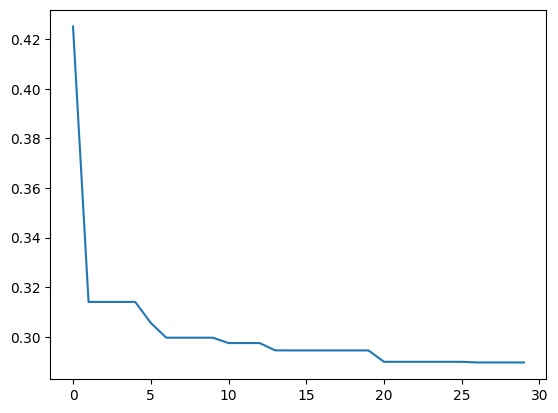

In [7]:
plt.plot(fitness_values_list)


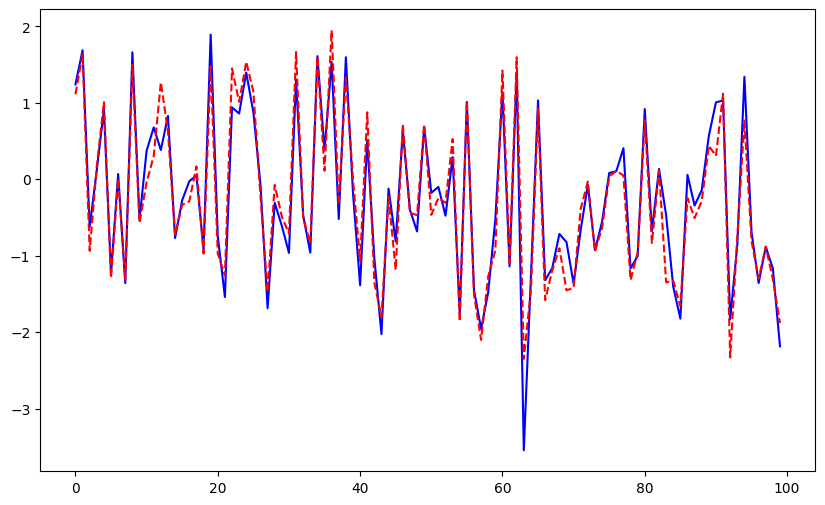

In [8]:
plt.figure(figsize=(10, 6))  
plt.plot(y_test,'b-')
plt.plot(y_pred,'r--')
# plt.plot(y_pred22,'g--')


In [ ]:
import numpy as np
from sklearn.svm import SVR
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 生成示例数据
# 这里假设你有一个包含输入和输出数据的数组 X 和 Y
# X = {u1(k), u2(k), u1(k-1), u2(k-1), y(k)}
# Y = {y(k+1)}


# 假设已经有LS-SVR模型的参数
# params = [5.33993953e+01 ,3.32226485e-02]
params = result_position
# 创建模型
my_svr_model = My_LS_SVRModel(params=params)
# 训练模型
my_svr_model.fit(X_train, y_train)


In [ ]:
# 生成参考轨迹
def get_yr(aim_value,current_value,alpha,P):

    # 生成设定信号
    setpoint_value = aim_value
    setpoint_signal = np.full(10, setpoint_value)
    # 初始化参数
    alpha = alpha
    y_r = np.zeros(P)
    y_r[0] = current_value
    # 模拟一阶模型
    for k in range(1,P):
        y_r[k] = alpha * y_r[k-1] + (1 - alpha) * setpoint_value


    # # 绘制结果
    # plt.plot(setpoint_signal, label='Setpoint Signal')
    # plt.plot(y_r,'o-', label='Output Signal (Tracked)')
    # plt.legend()
    # plt.xlabel('Time')
    # plt.ylabel('Amplitude')
    # plt.title('Tracking Setpoint Signal with One-Order Model')
    # plt.show()

    # print('y_r000',y_r)
    return y_r


In [ ]:
def my_MPC(k_data,params,M,P,k):
    k_data = k_data
    u1 = k_data[0:2]
    u2 = k_data[2:4]
    u1_1 = k_data[4:6]
    u2_1 = k_data[6:8]
    y1 = k_data[8:10]
    h, U1, U2  =params[0], params[1:M+1],params[M+1:]
    
    # ... 在这里放入原来计算 mse 的代码 ...
    u1   = np.concatenate((u1[:1],U1))
    u2   = np.concatenate((u2[:1],U2))
    u1_1 = np.concatenate((u1_1[:2],U1[:-1]))
    u2_1 = np.concatenate((u2_1[:2],U2[:-1]))
    y1   = np.concatenate((y1,np.zeros(P)))
    # print(u1)
    # print(u2)
    # print(u1_1)
    # print(u2_1)
    # print(y1)

    y1_k = y1[1]

    # print('y1_k',y1_k)

    # print('0000000000')
    for j in range(1):
        # print(j,M)
        # print('predict y1_m_k')
        x = np.column_stack((u1[j],u2[j],u1_1[j],u2_1[j],y1[j]))
        # print(x)
        y1_m_k = my_svr_model.predict(x)

        y1[j+1] = y1_m_k.item()###############################

        # print(y1_m_k)
        
        E_k = y1_k - y1_m_k
    #     print('E_k',E_k)
    # print('y1',y1)



    # print('MMMMMMMMMMM')
    for j in range(1,M+1):        
        # print(j,M)
        x = np.column_stack((u1[j],u2[j],u1_1[j],u2_1[j],y1[j]))
        # print(x)
        y1_k_j = my_svr_model.predict(x)
        # print(y1_k_j)            
        y1[j+1] = y1_k_j.item()#将预测值作为下一步的输出值

    # print('y1',y1)
        
        
    

    # print('PPPPPPPPPPP')
    for j in range(M+1,P+1):
        # print(j,P)
        x = np.column_stack((u1[-1],u2[-1],u1[-1],u2[-1],y1[j]))
        # print(x)
        y1_k_j = my_svr_model.predict(x)
        # print(y1_k_j)
        y1[j+1] = y1_k_j.item()#将预测值作为下一步的输出值
    

    # print(u1)
    # print(u2)
    # print(u1_1)
    # print(u2_1)
    # print(y1)


    # print('MSE----MSE----MSE----MSE----MSE----MSE----MSE----')

    # if k <30:
    #     aim = 0.5
    # elif k<60:
    #     aim = -0.5
    # else :
    #     aim = 0.5

    aim = -0.5
    if k == 50:
        aim = 0.5
    

    # print("y1_k  aim",y1_k,aim)
    y_r = get_yr(aim,y1_k,0.01,P)
    # print("y1_k  aim",y1_k,aim)
    # print('y_r',y_r)
    y1_M_k = y1[2:]
    # print('y1_M_k',y1_M_k)
    # print('y1',y1)
    lamda1 = 1
    lamda2 = 1
    mse = (np.sum((y_r-y1_M_k-h*E_k)**2)
            +np.sum(lamda1*(np.diff(u1)**2))
            +np.sum(lamda2*(np.diff(u2)**2))
            +np.sum((aim-y1_M_k)**2)*0.5
            )
    # print('',mse)

    k_data2 = np.concatenate((u1[1:3],u2[1:3],u1_1[1:3],u2_1[1:3],y1[1:3]),axis=0)
    return mse , y1[1] , k_data2




In [ ]:
import os, sys
# 设定控制多少周期Times
Times = 100
# 期望设定值
setpoint = np.full(Times, 0)
# MPC参数
P = 3  # 预测时域长度
M = 2  # 控制时域长度

import numpy as np
from scipy.optimize import minimize
randint = np.random.randint(1, num_samples-2-P-1)
randint =13
# print('randint',randint)
# 第一次的到下面五个变量，固定好格式
u1 = u1_data[randint:randint+2]
u2 = u2_data[randint:randint+2]
u1_1 = u1_data[randint-1:randint+2-1]
u2_1 = u2_data[randint-1:randint+2-1]
y1 = y1_data[randint:randint+2]
# print(u1)
# print(u2)
# print(u1_1)
# print(u2_1)
# print(y1)
# print(u1.shape,u2.shape)
# print(u1_1.shape,u2_1.shape)
# print(y1.shape)
k_data = np.concatenate((u1,u2,u1_1,u2_1,y1),axis=0)
# print(k_data)
#设置待优化控制序列，U
h = 0.1
U1 = np.arange(1,M+1) 
U2 = np.arange(10,M+10) 
y1_pred = np.zeros(M+1+1)  

all_pred = []
# MPC控制循环
for k in range(Times):
    # print('kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk',k)
    # 定义优化目标函数
    def objective_function(params, *k_data):
        # print('一次控制一次控制一次控制一次控制一次控制')
        # print('k_data', k_data)
        mse, y1m_k, k_data2 = my_MPC(k_data=k_data[0], params=params, M=M, P=P, k=k)
        # print('params', params)        
        return mse

    # 初始猜测值
    params = np.concatenate([np.array([0.1]), np.ones(M), np.ones(M)])
    # 定义参数的上下限  
    bounds = [(0, 1)] + [(-1, 1) for _ in range(2 * M)]
    # 进行优化  
    result = minimize(objective_function, params, method='L-BFGS-B', bounds=bounds, args=k_data)


    
    optimized_h, optimized_U1, optimized_U2 = result.x[0], result.x[1:M+1], result.x[M+1:]
    # print("Optimized h:", optimized_h)
    # print("Optimized U1:", optimized_U1)
    # print("Optimized U2:", optimized_U2)


    # print('获取最好的U1、U2下的响应:')
    params = np.concatenate(([optimized_h],optimized_U1,optimized_U2),axis=0)
    mse , y1m_k, k_data2=my_MPC(k_data=k_data,params=params,M=M,P=P,k=k)
    all_pred.append(y1m_k)
    k_data = k_data2





setpoint_signal = np.full(Times, 0.5)
plt.plot(setpoint_signal[0:], label='Setpoint Signal')
# plt.plot(y_r,'ro-', label='Output Signal (Tracked)')
plt.plot(all_pred[0:],'bo-', label='Output Signal (Tracked)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Tracking Setpoint Signal with One-Order Model')
plt.show()



In [ ]:
setpoint_signal = np.full(Times, 0.5)
# plt.plot(y_r,'ro-', label='Output Signal (Tracked)')
plt.plot(all_pred[0:10],'bo-', label='Output Signal (Tracked)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Tracking Setpoint Signal with One-Order Model')
plt.show()


In [ ]:
all_pred[0]
